<a href="https://colab.research.google.com/github/Suhit97/U-Net-Image-segmentation/blob/main/U_Net_for_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np


###Download the Oxford-IIIT Pets dataset


In [ ]:
# If you hit a problem with checksums, you can execute the following line first
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKAEKNV/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKAEKNV/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
print(dataset.keys())

dict_keys(['test', 'train'])


## Prepare the dataset
You will now prepare the train and test sets. The following utility functions preprocess the data. These include:

    simple augmentation by flipping the image
    normalizing the pixel values
    resizing the images



#### Label 	Class Name
####1 	foreground
####2 	background
####3 	Not Classified

For convenience, let's subtract 1 from these values and we will interpret these as {'pet', 'background', 'outline'}:

#### Label 	Class Name
####0  pet
####1 	background
####2 	outline

In [ ]:

def random_flip(input_image, input_mask):
  '''does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask



def normalize(input_image, input_mask):
  '''
  normalizes the input image pixel values to be from [0,1].
  subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask



@tf.function
def load_image_train(datapoint):
  '''resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask


def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
# Utilities to help us visualize our data and metrics
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

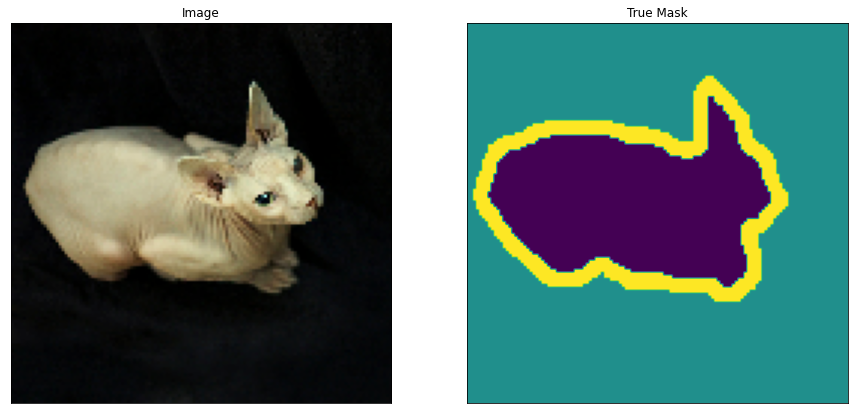

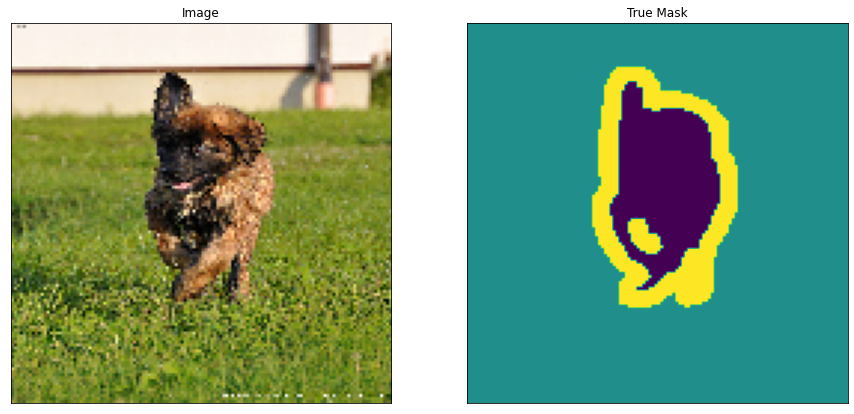

In [ ]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

## Defining the u net model


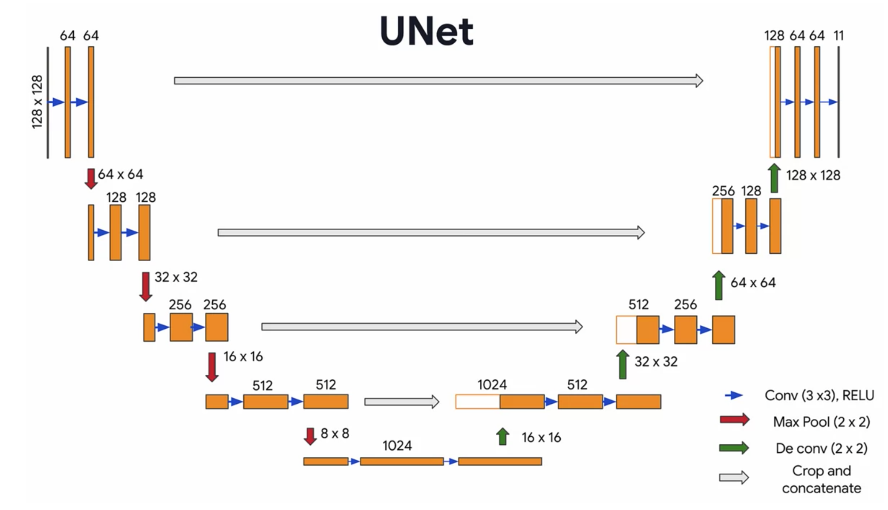



### Encoder

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  
  #Adds 2 convolutional layers with the parameters passed to it  
  # first layer
  
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck

In [ ]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

### Decoder

In [ ]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  
  #Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Finally putting them together

In [ ]:


OUTPUT_CHANNELS = 3

def unet():
 

  
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model


model = unet()


model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

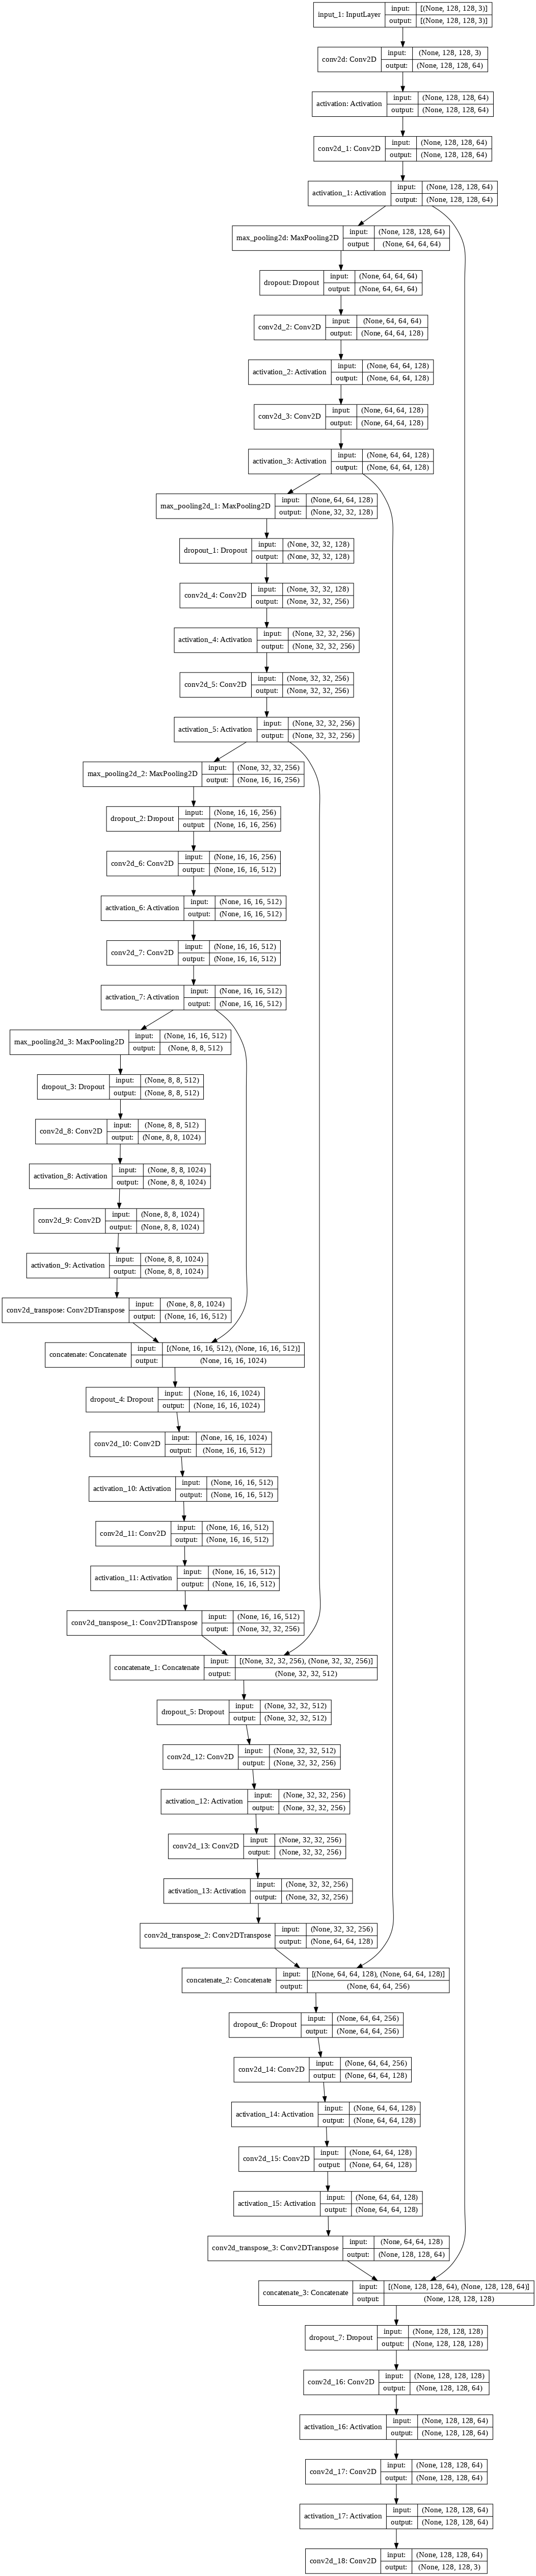

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

## Training the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
 2/57 [>.............................] - ETA: 1:37:59 - loss: 1.2530 - accuracy: 0.4854

KeyboardInterrupt: ignored

In [ ]:
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

## Making Predictions

In [ ]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [ ]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [ ]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

In [ ]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

In [ ]:


# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

